# Running a ViT on a single GPU

There are alot of constraints on running a ViT on a GPU. Due to the unconstrained nature of attention mechanism, ViT considers relationships between all pairs in the pixels in the image. This operation is computationally expensive and requires alot of memory to store the intermediate computation. Therefore we must strike a balance between the computationally expensive nature of attention and the state-of-the-art capabilities of vision tranformers. 

### Training ViTs on Smaller Datasets

Dosovitskiy, Alexey, et al used the following datasets to train their proposed ViT: 

- ILSVRC-2012 ImageNet dataset with 1k classes and 1.3M images
- Superset ImageNet-21k with 21k classes and 14M images (Deng et al., 2009)
- JFT (Sun et al., 2017) with 18k classes and 303M high-resolution images

It should be noted that JFT is a large private labelled dataset with a staggering 300 million images in comparison to ImageNet which has only 1.3 Million labelled images in comparison. Training on such a large dataset requires large training times and exceeds the capacity of a single GPU. However, using attentive knowledge distillation, Touvron, Hugo, et al. trained a vision transformer that attained SOTA while being trained on ImageNETs only. It took them two-three days to acheive this task using a single 8-GPU node. While a remarkable reduction in data size, learning from scratch is still not easily acheivable with the compute resources that we have on our hands. 

Further improving this result is the work by the authors of "DearKD" who targeted knowledge distillation in the early stages of training for vision transformers. The authors of the paper first distill the inductive baises from the early intermediate layers of a CNN and then give vision transformers free reign to integrate information globally. Despite these introductions that allievate the expensive nature of attention by constraining it locally, the experiments in the paper were all performed on ImageNet. This goes on to highlight how Vision Transformers are fundamentally tailored towards large-datasets to acheive statisfactory results. 

All this leads us to ask ourselves the following question: *Is to possible to train vision transformers on small datasets and still acheive acceptable visual representation?* In this notebook, we would consider some approaches implemented by selected papers to acheive this. Firstly, we begin with the paper **Vision Transformers for Small-Size Datasets**. The authors introduce the following novelties: 

1. Shifted Patch Tokenization
2. Locality Self-Attention 





## Shifted Patch Tokenization

![Shifted Images](Shifted_images.png)

The authors state that the idea of SPT was derived from Temporal Shift Module (TSM) . TSM is effective temporal modeling which shifts some temporal channels of features. Inspired by this, they propose effective spatial modeling that tokenizes spatially shifted images together with the input image in order to increase the local inductive bias of transformers. 

Consider an image $\vec{x}$ the features are shifted by half the patch size in four diagonal directions as shown in the figure above. That is, left-up, right-up, left-down, and right-down. We denote the transformation of shifts by $S$ and shifted image as $s^i$. 
$$
P[x_s^1, \ldots, x_s^{N_s}] 
$$

Next, visual tokens are obtained through layer normalization (LN) and linear projection via matrix $E_s$:
$$
S(x) = LN(P([x_s^1, \ldots, x_s^{N_s}])) E_s 
$$

We then add class token $x_{\text{cls}}$ and learnable positional embeddings $E_{\text{pos}}$. These are concatenated with $S(x)$:
$$
S_{\text{pe}}(x) = \left\{
\begin{array}{ll}
[x_{\text{cls}}; S(x) + E_{\text{pos}}] & \text{if } x_{\text{cls}} \text{ exists} \\
S(x) + E_{\text{pos}} & \text{otherwise}
\end{array}
\right. 
$$

Where $x_{\text{cls}} \in \mathbb{R}^{d_s}$ is a class token and $E_{\text{pos}} \in \mathbb{R}^{(N+1) \times d_s}$ is the learnable positional embedding. Also, $N$ is the number of embedded tokens.

Consider the key-value matrix: 

$$
R(x) = xE_q (xE_k)^T 
$$

Here, $E_q \in \mathbb{R}^{d \times d_q}$ and $E_k \in \mathbb{R}^{d \times d_k}$ indicate learnable linear projections for Query and Key, respectively. And, $d_q$ and $d_k$ are the dimensions of Query and Key, respectively.

Now, the authors note the following: due to the following two causes, attentions of standard ViT tend to be similar to each other regardless of relations. The first cause is as follows: Since Query $(xE_q)$ and Key $(xE_k)$ are linearly projected from the same input tokens, token vectors belonging to Query and Key tend to have similar sizes. $R$ is the dot product of Query and Key. So, self-token relations which are dot products of similar vectors are usually larger than inter-token relations. Therefore, the subsequent softmax function gives relatively high scores to self-token relations and small scores to inter-token relations.

The second cause is as follows: The reason why $R$ is divided by $\sqrt{d_k}$ in is to prevent the softmax function from having a small gradient. However, $\sqrt{d_k}$ can rather act as a high temperature of the softmax function and cause smoothing of the attention score distribution.

To mitigate these two effects, they intoduce *diagonal masking* and reducing the value of the constant $\sqrt{D_k}$


## Locality Self-attention

Secondly, they propose Locality Self-Attention (LSA), which allows ViT to attend locally. LSA mitigates the smoothing phenomenon of attention score distribution by excluding self-tokens and by applying learnable temperature to the softmax function

Diagonal masking plays a role in giving larger scores to inter-token relations by excluding self-token relations from the softmax operation. Specifically, diagonal masking forces $-\infty$ on diagonal components of $R$. This makes ViT’s attention more focused on other tokens rather than attending to its own tokens. The proposed diagonal masking is defined by:

$$
R_{i,j}^M(x) = 
\begin{cases} 
R_{i,j}(x) & \text{if } i \neq j \\
-\infty & \text{if } i = j
\end{cases} 
$$

Where $R_{i,j}^M(x)$ indicates each component of the masked similarity matrix.

The second technique for LSA is the learnable temperature scaling, which allows ViT to determine the softmax temperature by itself during the learning process. The figure above shows the average learned temperature according to depth when the softmax temperature is used as the learnable parameter in the following equation:

$$
SA(x) = \text{softmax}\left(\frac{R}{\sqrt{d_k}}\right)xE_v 
$$

Note that the average learned temperature is lower than the constant temperature of standard ViT. In general, the low temperature of softmax sharpens the score distribution. Therefore, the learnable temperature scaling sharpens the distribution of attention scores. Based on Eq. 6, the LSA with both diagonal masking and learnable temperature scaling applied is defined by:

$$
L(x) = \text{softmax}\left(\frac{R^M(x)}{\tau}\right)xE_v
$$

Where $\tau$ is the learnable temperature.

In other words, LSA solves the smoothing problem of the attention score distribution.

# Importing Libraries 


In [3]:
import torch
import torch.nn as nn
from torchvision import datasets, transforms
from torch.utils.data import Dataset, DataLoader
import os
from torchsummary import summary
import matplotlib.pyplot as plt
import cv2
from tqdm.notebook import tqdm
import numpy as np
import torchvision
from torch import nn, optim

import torch.nn.functional as Fe
import torchvision.transforms.functional as F


#### Loading CIFAR

In [4]:
train_transform = transforms.Compose([
    transforms.RandomRotation(10),  # random rotation  
    transforms.RandomHorizontalFlip(), # random flips 
    transforms.ToTensor(),  
])


test_transforms = transforms.Compose([
    transforms.ToTensor()
])

train_data = datasets.CIFAR10(
    root = "data", 
    train = True, 
    download = True,
    transform = train_transform,
    target_transform=None
)

test_data = datasets.CIFAR10(
    root = "data",
    train = False, #get test data
    download = True,
    transform = test_transforms
)


#lets get an image and see its dimension size. I want to check if they are all of same [H,W] 
# or we will need to transform them and make them so. 


image,label = train_data[0]
print(image.shape) 
print(label)


Files already downloaded and verified
Files already downloaded and verified
torch.Size([3, 32, 32])
6


In [5]:
# getting our train_loader and test_loader 
BATCH_SIZE = 128

train_loader = DataLoader(test_data,
                         batch_size = BATCH_SIZE,
                         shuffle = True)

test_loader = DataLoader(test_data,
                         batch_size = BATCH_SIZE,
                         shuffle = True # doesn't matter. you can turn it to false also.  
                        )

print(f"Dataloaders: {train_loader, test_loader}") 
print(f"Length of train dataloader: {len(train_loader)} batches of {BATCH_SIZE}")
print(f"Length of test dataloader: {len(test_loader)} batches of {BATCH_SIZE}")

Dataloaders: (<torch.utils.data.dataloader.DataLoader object at 0x000001CA41AA2CD0>, <torch.utils.data.dataloader.DataLoader object at 0x000001CA41AA2C40>)
Length of train dataloader: 79 batches of 128
Length of test dataloader: 79 batches of 128


### Visualize the Dataset


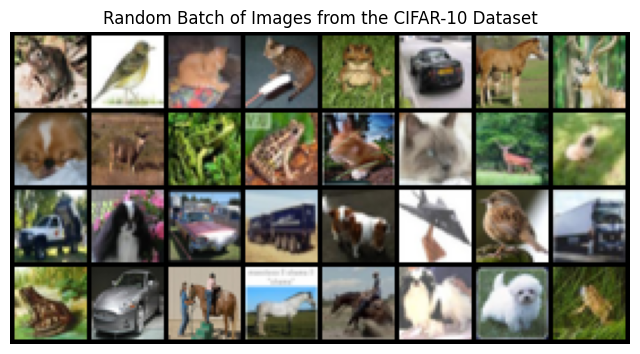

In [6]:
def imshow(img):
    img = img
    npimg = img.numpy()
    plt.figure(figsize=(8, 8))
    plt.imshow(np.transpose(npimg, (1, 2, 0)))
    plt.axis('off')
    plt.title("Random Batch of Images from the CIFAR-10 Dataset")
    plt.show()

# Get a batch of training data
dataiter = iter(train_loader)
images, _ = next(dataiter)

# Show images
imshow(torchvision.utils.make_grid(images[0:32]))

### Parameters for our Transformer: 

In [7]:
IMAGE_SIZE = 32  # CIFAR-10 images are 32x32 pixels
PATCH_SIZE = 4  # This we will adjust as needed depending upon some experiments
NUM_PATCHES = (IMAGE_SIZE // PATCH_SIZE) ** 2
PROJECTION_DIM = 128  # Example projection dimension, adjust as needed
LAYER_NORM_EPS = 1e-6  # Layer norm epsilon


## Shifted Patch Tokenization

See previous notebook for details. 

In [8]:
def crop_shift_pad(images, mode, half_patch, image_size):
    if mode == "left-up":
        crop_height = half_patch
        crop_width = half_patch
        shift_height = 0
        shift_width = 0
    elif mode == "left-down":
        crop_height = 0
        crop_width = half_patch
        shift_height = half_patch
        shift_width = 0
    elif mode == "right-up":
        crop_height = half_patch
        crop_width = 0
        shift_height = 0
        shift_width = half_patch
    else:
        crop_height = 0
        crop_width = 0
        shift_height = half_patch
        shift_width = half_patch

    crop = F.crop(images, crop_height, crop_width, image_size - half_patch, image_size - half_patch)
    shift_pad = F.pad(crop, (shift_width, 0, shift_height, 0))  # pad(left, right, top, bottom)
    
    shifted_resized = F.resize(shift_pad, (image_size, image_size))

    return shifted_resized

In [9]:
class ShiftedPatchTokenization(nn.Module):
    def __init__(self, image_size, patch_size, projection_dim,flatten):
        super().__init__()
        self.image_size = image_size
        self.patch_size = patch_size
        self.half_patch = patch_size // 2
        self.projection_dim = projection_dim
        self.layer_norm = nn.LayerNorm(5*patch_size * patch_size * 3) # multiplied by 5 because we are creating
                                                                                    # 4 copies + the image
            
        self.projection = nn.Linear(5*patch_size * patch_size * 3, projection_dim) # multiplied by 5 because we are creating
                                                                                    # 4 copies + the image 
        self.flatten = flatten 
        
    def crop_shift_pad(self, images, mode):
        # Shift image based on mode and pad
        return crop_shift_pad(images, mode, self.half_patch, self.image_size)

    def img_to_patch(self, x):
        # Extract patches from the image
        B, C, H, W = x.shape
        x = x.reshape(B, C, H // self.patch_size, self.patch_size, W // self.patch_size, self.patch_size)
        x = x.permute(0, 2, 4, 1, 3, 5)  # [B, H', W', C, p_H, p_W]
        x = x.flatten(1, 2)  # [B, H'*W', C, p_H, p_W]
        if self.flatten:
            x = x.flatten(2, 4)  # [B, H'*W', C*p_H*p_W]
            
            # This part is important. We now take all the patches along the batch and concactenate them together 
            # to create higher-dimensional patches. 
            x = x.transpose(0, 1)  # [H'*W', B, C*p_H*p_W]
            x = x.flatten(1, 2)  # [H'*W', B * C * p_H * p_W]
            x = x.unsqueeze(0)  # Add batch dimension: [1, H'*W', B * C * p_H * p_W]

        return x
        

    def forward(self, images):
        modes = ["left-up", "left-down", "right-up", "right-down", "original"]
        shifted_images = []

        for mode in modes:
            if mode == "original":
                shifted_images.append(F.resize(images, (self.image_size, self.image_size)))
            else:
                shifted_images.append(self.crop_shift_pad(images, mode))

        # Concatenate the diagonally shifted images with the original image
        concatenated_image = torch.cat(shifted_images, dim=0)

        # Extract patches
        patches = self.img_to_patch(concatenated_image)
        if self.flatten:
            # Flatten the spatial dimensions of all patches and layer normalize
            patches = patches.flatten(2)
            patches = self.layer_norm(patches)

            # Project the flattened patches
            patches = self.projection(patches)

        return patches



# Implementing Locality Self Attention 

In [10]:
import torch.nn.functional as Fe


def scaled_dot_product(q, k, v, mask=None, tau=None):
    
    # Scale q tau rather than d_k 
    q = q / (tau) # originally it was q = q / \sqrt(d_k)

    attn_logits = torch.matmul(q, k.transpose(-2, -1))

    if mask is not None:
        batch_size = attn_logits.shape[0]
        mask = torch.ones((batch_size, 4, 64, 64), dtype=torch.int8)
        for i in range(batch_size):
            for j in range(4):
                torch.diagonal(mask[i, j]).fill_(0)
        attn_logits = attn_logits.masked_fill(mask == 0, float('-inf'))

    attn_weights = Fe.softmax(attn_logits, dim=-1)

    output = torch.matmul(attn_weights, v)
    return output, attn_weights

In [11]:
class MultiheadAttentionLSA(nn.Module):

    def __init__(self, input_dim, embed_dim, num_heads):
        super().__init__()
        assert embed_dim % num_heads == 0, "Embedding dimension must be 0 modulo number of heads."

        self.embed_dim = embed_dim
        self.num_heads = num_heads
        self.dropout = dropout
        
        self.head_dim = embed_dim // num_heads

        # Stack all weight matrices 1...h together for efficiency
        # Note that in many implementations you see "bias=False" which is optional
        self.qkv_proj = nn.Linear(input_dim, 3*embed_dim)
        self.o_proj = nn.Linear(embed_dim, embed_dim)

        self.tau = nn.Parameter(torch.sqrt(torch.tensor(float(embed_dim))))

    def _reset_parameters(self):
        # Original Transformer initialization, see PyTorch documentation
        nn.init.xavier_uniform_(self.qkv_proj.weight)
        self.qkv_proj.bias.data.fill_(0)
        nn.init.xavier_uniform_(self.o_proj.weight)
        self.o_proj.bias.data.fill_(0)

    def forward(self, x, mask=None, return_attention=False):
        batch_size, seq_length, _ = x.size()

        qkv = self.qkv_proj(x)

        # Separate Q, K, V from linear output
        qkv = qkv.reshape(batch_size, seq_length, self.num_heads, 3*self.head_dim)
        qkv = qkv.permute(0, 2, 1, 3) # [Batch, Head, SeqLen, Dims]
        q, k, v = qkv.chunk(3, dim=-1)

        # Determine value outputs
        values, attention = scaled_dot_product(q, k, v, mask=mask,tau=self.tau)
        values = values.permute(0, 2, 1, 3) # [Batch, SeqLen, Head, Dims]
        values = values.reshape(batch_size, seq_length, self.embed_dim)
        o = self.o_proj(values)

        if return_attention:
            return o, attention
        else:
            return o

In [12]:
class AttentionBlock(nn.Module):
    def __init__(self, embed_dim, hidden_dim, num_heads,mask, dropout=0.0):
        """Attention Block.

        Args:
            embed_dim: Dimensionality of input and attention feature vectors
            hidden_dim: Dimensionality of hidden layer in feed-forward network
                         (usually 2-4x larger than embed_dim)
            num_heads: Number of heads to use in the Multi-Head Attention block
            dropout: Amount of dropout to apply in the feed-forward network
        """
        super().__init__()
        
        self.attn = nn.MultiheadAttentionLSA(embed_dim, num_heads)
        self.layer_norm_2 = nn.LayerNorm(embed_dim)
        self.linear = nn.Sequential(
            nn.Linear(embed_dim, hidden_dim),
            nn.GELU(),
            nn.Dropout(dropout),
            nn.Linear(hidden_dim, embed_dim),
            nn.Dropout(dropout),
        )

    def forward(self, x):
        inp_x = x
        x = x + self.attn(inp_x, inp_x, inp_x)[0]
        x = x + self.linear(self.layer_norm_2(x))
        return x

In [13]:
class TransformerBlock(nn.Module):
    def __init__(self, input_dim, embed_dim, num_heads, hidden_dim, mask = None):
        super().__init__()
        # Ensure the MultiheadAttentionLSA is initialized with correct parameters
        self.mask = mask
        
        self.attention = MultiheadAttentionLSA(input_dim=input_dim, embed_dim=embed_dim, num_heads=num_heads)
        self.mlp = nn.Sequential(
            nn.Linear(embed_dim, hidden_dim),
            nn.GELU(),
            nn.Linear(hidden_dim, embed_dim),
        )
        self.norm1 = nn.LayerNorm(embed_dim)
        self.norm2 = nn.LayerNorm(embed_dim)

    def forward(self, x):
        x2 = self.norm1(x)
        attention_output = self.attention(x2, mask=self.mask)
        x = x + attention_output
        x2 = self.norm2(x)
        x = x + self.mlp(x2)
        return x

In [14]:
class VisionTransformer(nn.Module):
    def __init__(self, image_size, patch_size, projection_dim, num_heads, num_layers, num_classes, hidden_dim, mask, dropout=0.0):
        super().__init__()
        
        self.flatten = True 

        self.patch_tokenizer = ShiftedPatchTokenization(image_size=image_size, patch_size=patch_size, projection_dim=projection_dim,flatten = self.flatten)
        self.cls_token = nn.Parameter(torch.zeros(1, 1, projection_dim))
        self.pos_embed = nn.Parameter(torch.zeros(1, (image_size // patch_size) ** 2, projection_dim)) # WILL HAVE TO DO + 1 IF CLS TOKENS ADDED
        self.dropout = nn.Dropout(dropout)

        self.transformer_layers = nn.ModuleList()
        for _ in range(num_layers):
            # Assuming input_dim is the same as projection_dim or define it appropriately based on your model's architecture
            transformer_block = TransformerBlock(input_dim=projection_dim, embed_dim=projection_dim, num_heads=num_heads, hidden_dim=hidden_dim,mask = mask)
            self.transformer_layers.append(transformer_block)

        self.mlp_head = nn.Sequential(
            nn.LayerNorm(projection_dim),
            nn.Linear(projection_dim, num_classes)
        )

    def forward(self, x):
        
        ## we will send each image one-by-one 
        batch_size, channels, height, width = x.shape
        output_list = []
        for i in range(batch_size):
            single_image = x[i].unsqueeze(0)  # Adds a batch dimension, resulting in [1, 3, 32, 32]
            processed_image = self.patch_tokenizer(single_image)
            output_list.append(processed_image)

        x = torch.cat(output_list, dim=0)
        batch_size, num_patches, _ = x.shape
        # FOR NOW, DON'T ADD THIS
        #cls_tokens = self.cls_token.expand(batch_size, -1, -1)
        #print("shape of cls_token is ", cls_tokens.shape)
        #x = torch.cat((cls_tokens, x), dim=1)

        x += self.pos_embed

        x = self.dropout(x)

        for layer in self.transformer_layers:
            x = layer(x)

        cls_token_final = x[:, 0]
        out = self.mlp_head(cls_token_final)

        return out


In [15]:
image_size = 32
patch_size = 4  # Divide 32x32 image into 8x8 patches
projection_dim = 64  # Example projection dimension
num_heads = 4  # Example number of heads
num_layers = 4  # Example number of layers
num_classes = 10  
hidden_dim = 128  
dropout = 0.1  


In [16]:
BATCH_SIZE
mask = torch.ones((BATCH_SIZE, 4, 64, 64), dtype=torch.int8)
for i in range(128):
    for j in range(4):
        torch.diagonal(mask[i, j]).fill_(0)
diag_attn_mask = mask

In [17]:
vit_model = VisionTransformer(
    image_size=image_size,
    patch_size=patch_size,
    projection_dim=projection_dim,
    num_heads=num_heads,
    num_layers=num_layers,
    num_classes=num_classes,
    hidden_dim=hidden_dim,
    mask = diag_attn_mask,
    dropout=dropout
)

# Training our Model 

In [18]:
num_epochs = 50

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = vit_model.to(device)
optimizer = torch.optim.Adam(model.parameters(), lr=1e-3)
criterion = nn.CrossEntropyLoss()

for epoch in range(num_epochs):
    model.train()  # Set model to training mode
    running_loss = 0.0
    correct = 0
    total = 0

    for batch_idx, (images, labels) in enumerate(train_loader):
        images, labels = images.to(device), labels.to(device)

        optimizer.zero_grad()
        outputs = model(images)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        running_loss += loss.item()
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

        if batch_idx % 100 == 0:  # adjust print frequency as needed
            print(f'Epoch {epoch+1}, Batch {batch_idx}, Loss: {loss.item()}')

    epoch_loss = running_loss / len(train_loader)
    training_accuracy = 100 * correct / total
    print(f'Epoch {epoch+1}, Average Loss: {epoch_loss:.4f}, Training Accuracy: {training_accuracy:.2f}%')

    # Evaluate on test data
    model.eval()
    test_correct = 0
    test_total = 0
    with torch.no_grad():
        for images, labels in test_loader:
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)
            _, predicted = torch.max(outputs.data, 1)
            test_total += labels.size(0)
            test_correct += (predicted == labels).sum().item()

    test_accuracy = 100 * test_correct / test_total
    print(f'Epoch {epoch+1}, Test Accuracy: {test_accuracy:.2f}%')

C:\Users\AWCD\anaconda3\lib\site-packages\torchvision\transforms\functional.py:1603: UserWarning: The default value of the antialias parameter of all the resizing transforms (Resize(), RandomResizedCrop(), etc.) will change from None to True in v0.17, in order to be consistent across the PIL and Tensor backends. To suppress this warning, directly pass antialias=True (recommended, future default), antialias=None (current default, which means False for Tensors and True for PIL), or antialias=False (only works on Tensors - PIL will still use antialiasing). This also applies if you are using the inference transforms from the models weights: update the call to weights.transforms(antialias=True).
  warnings.warn(


Epoch 1, Batch 0, Loss: 2.457582473754883
Epoch 1, Average Loss: 1.9861, Training Accuracy: 26.14%
Epoch 1, Test Accuracy: 29.01%
Epoch 2, Batch 0, Loss: 1.9058290719985962
Epoch 2, Average Loss: 1.7944, Training Accuracy: 33.40%
Epoch 2, Test Accuracy: 35.73%
Epoch 3, Batch 0, Loss: 1.7858713865280151
Epoch 3, Average Loss: 1.6776, Training Accuracy: 37.45%
Epoch 3, Test Accuracy: 39.79%
Epoch 4, Batch 0, Loss: 1.6352214813232422
Epoch 4, Average Loss: 1.6091, Training Accuracy: 40.74%
Epoch 4, Test Accuracy: 44.75%
Epoch 5, Batch 0, Loss: 1.7445316314697266
Epoch 5, Average Loss: 1.5093, Training Accuracy: 44.36%
Epoch 5, Test Accuracy: 47.65%
Epoch 6, Batch 0, Loss: 1.492871880531311
Epoch 6, Average Loss: 1.4432, Training Accuracy: 46.76%
Epoch 6, Test Accuracy: 51.95%
Epoch 7, Batch 0, Loss: 1.339981198310852
Epoch 7, Average Loss: 1.3681, Training Accuracy: 49.98%
Epoch 7, Test Accuracy: 52.29%
Epoch 8, Batch 0, Loss: 1.2729263305664062
Epoch 8, Average Loss: 1.3076, Training Acc

KeyboardInterrupt: 

# Conclusion and next implementation

In this exposition, we introduced a model that aims to mitigate the lower generalizibility of VITs for small datasets, implementing the model given by  [Vision Transformer for Small-Size Datasets](https://arxiv.org/abs/2112.13492v1). My main aim in performing this task was to familiarize myself with challenges that one faces when considering ViTs for small datasets. This notebook serves as a foothold for further exploring papers such as [Understanding Why ViT Trains Badly on Small
Datasets: An Intuitive Perspective](https://arxiv.org/pdf/2302.03751.pdf) and [CoAtNet: Marrying Convolution and Attention for All Data Sizes](https://arxiv.org/pdf/2106.04803.pdf). Furthermore, it gives me a baseline model which I can tinker around to get useful metrics such as KL divergence between the representations of intermediate heads as well as heatmaps for various attention layers.  

Since we are going to be working for smaller dataset for this project, I believe that a close examination of ViT performance on datasets such as CIFAR-10, CIFAR-100 and TinyImageNet will help me better understand the inductive biases that needs to be effectively distilled in these transformers so their accuracy can be increased. For the next notebook, I will move on and directly implement a knowledge distillation method tailored for Vision transformers on small datasets. The paper I will be now concerning myself with is [Knowledge Distillation via the Target-aware Transformer](https://arxiv.org/abs/2205.10793). 

